**STEP 1:   IMPORTING LIBRARIES**

In [1]:
!pip install xgboost


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import xgboost
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score,mean_squared_error
from time import time
from sklearn.metrics import r2_score
import os
from sklearn.model_selection import train_test_split
#Machine Learning
from sklearn.ensemble import AdaBoostRegressor

In [3]:
data = pd.read_csv('kc_house_data.csv')

In [4]:
# Copying data to another dataframe df_train for our convinience so that original dataframe remain intact.
df_train=data.copy()
df_train.rename(columns ={'price': 'SalePrice'}, inplace =True)

In [5]:
# Now lets see the first five rows of the data
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


**STEP 2:  DATA CLEANING AND PREPROCESSING**

In [6]:
print(len(data))
# Check the number of features in the data set
print(len(data.columns))
# Check the data types of each column
print(data.dtypes)

21613
21
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


In [7]:
# Check any number of columns with NaN or missing values 
print(data.isnull().any().sum(), ' / ', len(data.columns))


0  /  21


In [8]:
# Check any number of data points with NaN
print(data.isnull().any(axis=1).sum(), ' / ', len(data))

0  /  21613


**STEP 3 : FINDING CORRELATION**

In [9]:
# As id and date columns are not important to predict price so we are discarding it for finding correlation
features = data.iloc[:,3:].columns.tolist()
target = data.iloc[:,2].name

In [10]:
# Finding Correlation of price with other variables to see how many variables are strongly correlated with price
correlations = {}
for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [11]:
# Printing all the correlated features value with respect to price which is target variable
# Checking Corelation with price 
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
sqft_living vs price,0.702035
grade vs price,0.667434
sqft_above vs price,0.605567
sqft_living15 vs price,0.585379
bathrooms vs price,0.525138
view vs price,0.397293
sqft_basement vs price,0.323816
bedrooms vs price,0.308350
lat vs price,0.307003
waterfront vs price,0.266369


**STEP 4 : EDA or DATA VISUALIZATION **

Let's explore the data

<Axes: xlabel='sqft_living15', ylabel='price'>

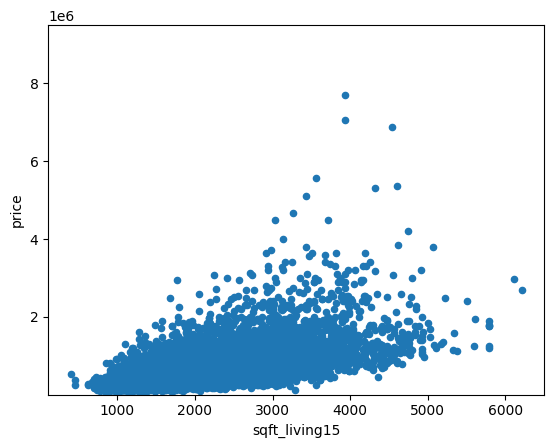

In [12]:
var = 'sqft_living15'
data = pd.concat([data['price'], data[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(3,9500000))

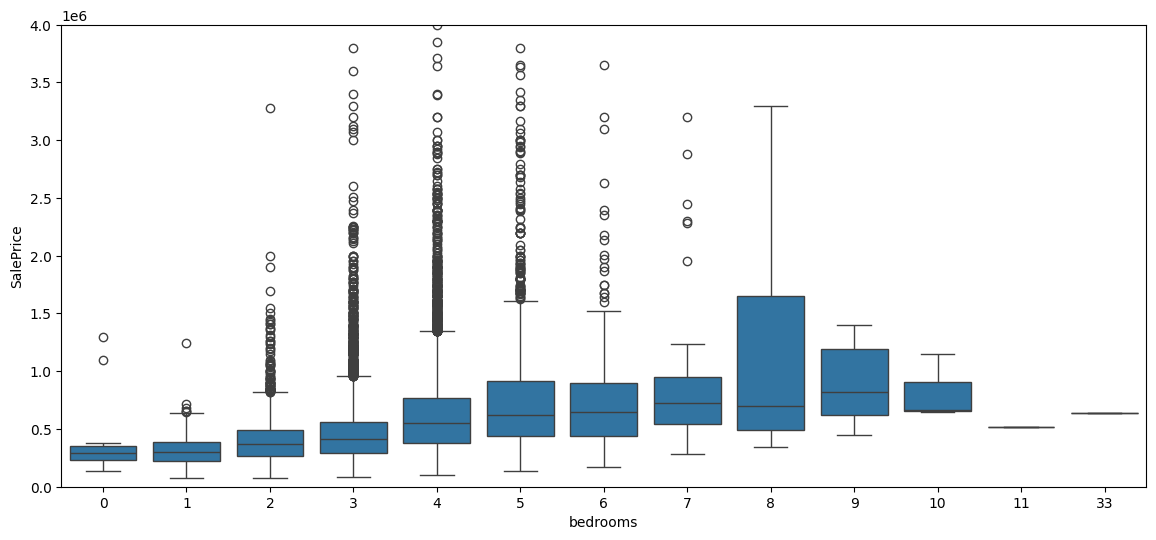

In [13]:
var = 'bedrooms'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=4000000);

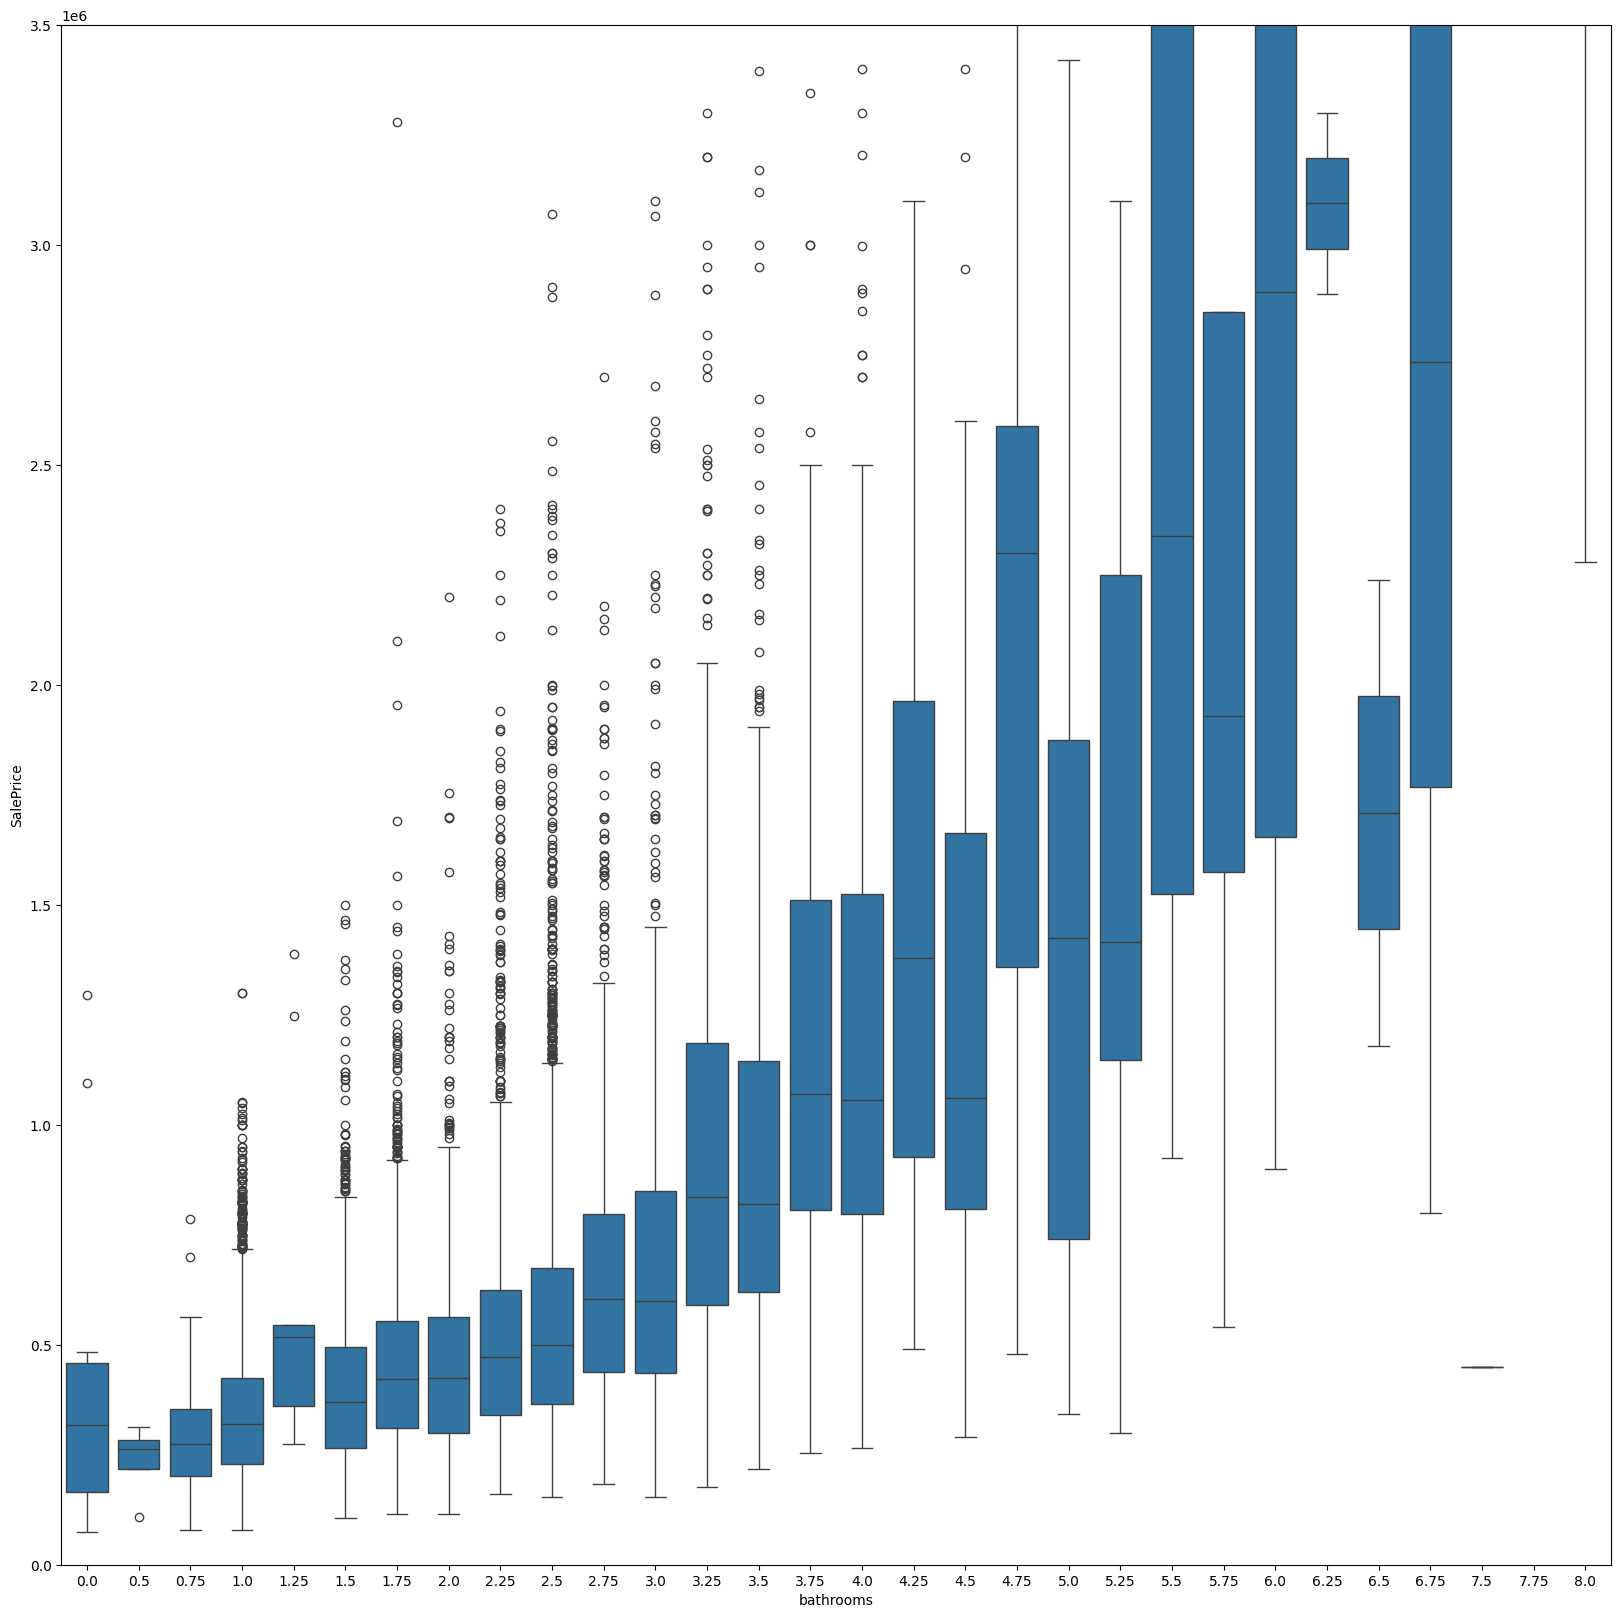

In [14]:
var = 'bathrooms'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 20))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);

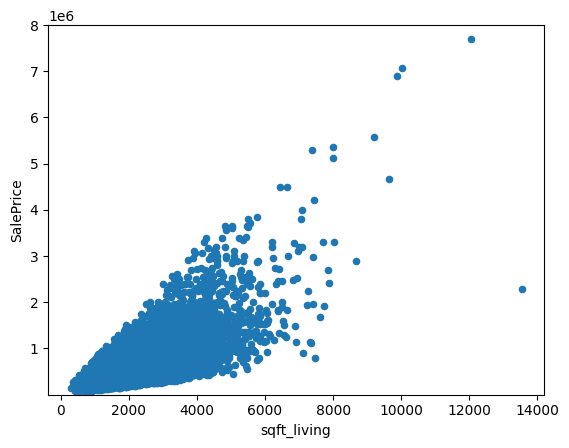

In [15]:
var = 'sqft_living'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(3,8000000));


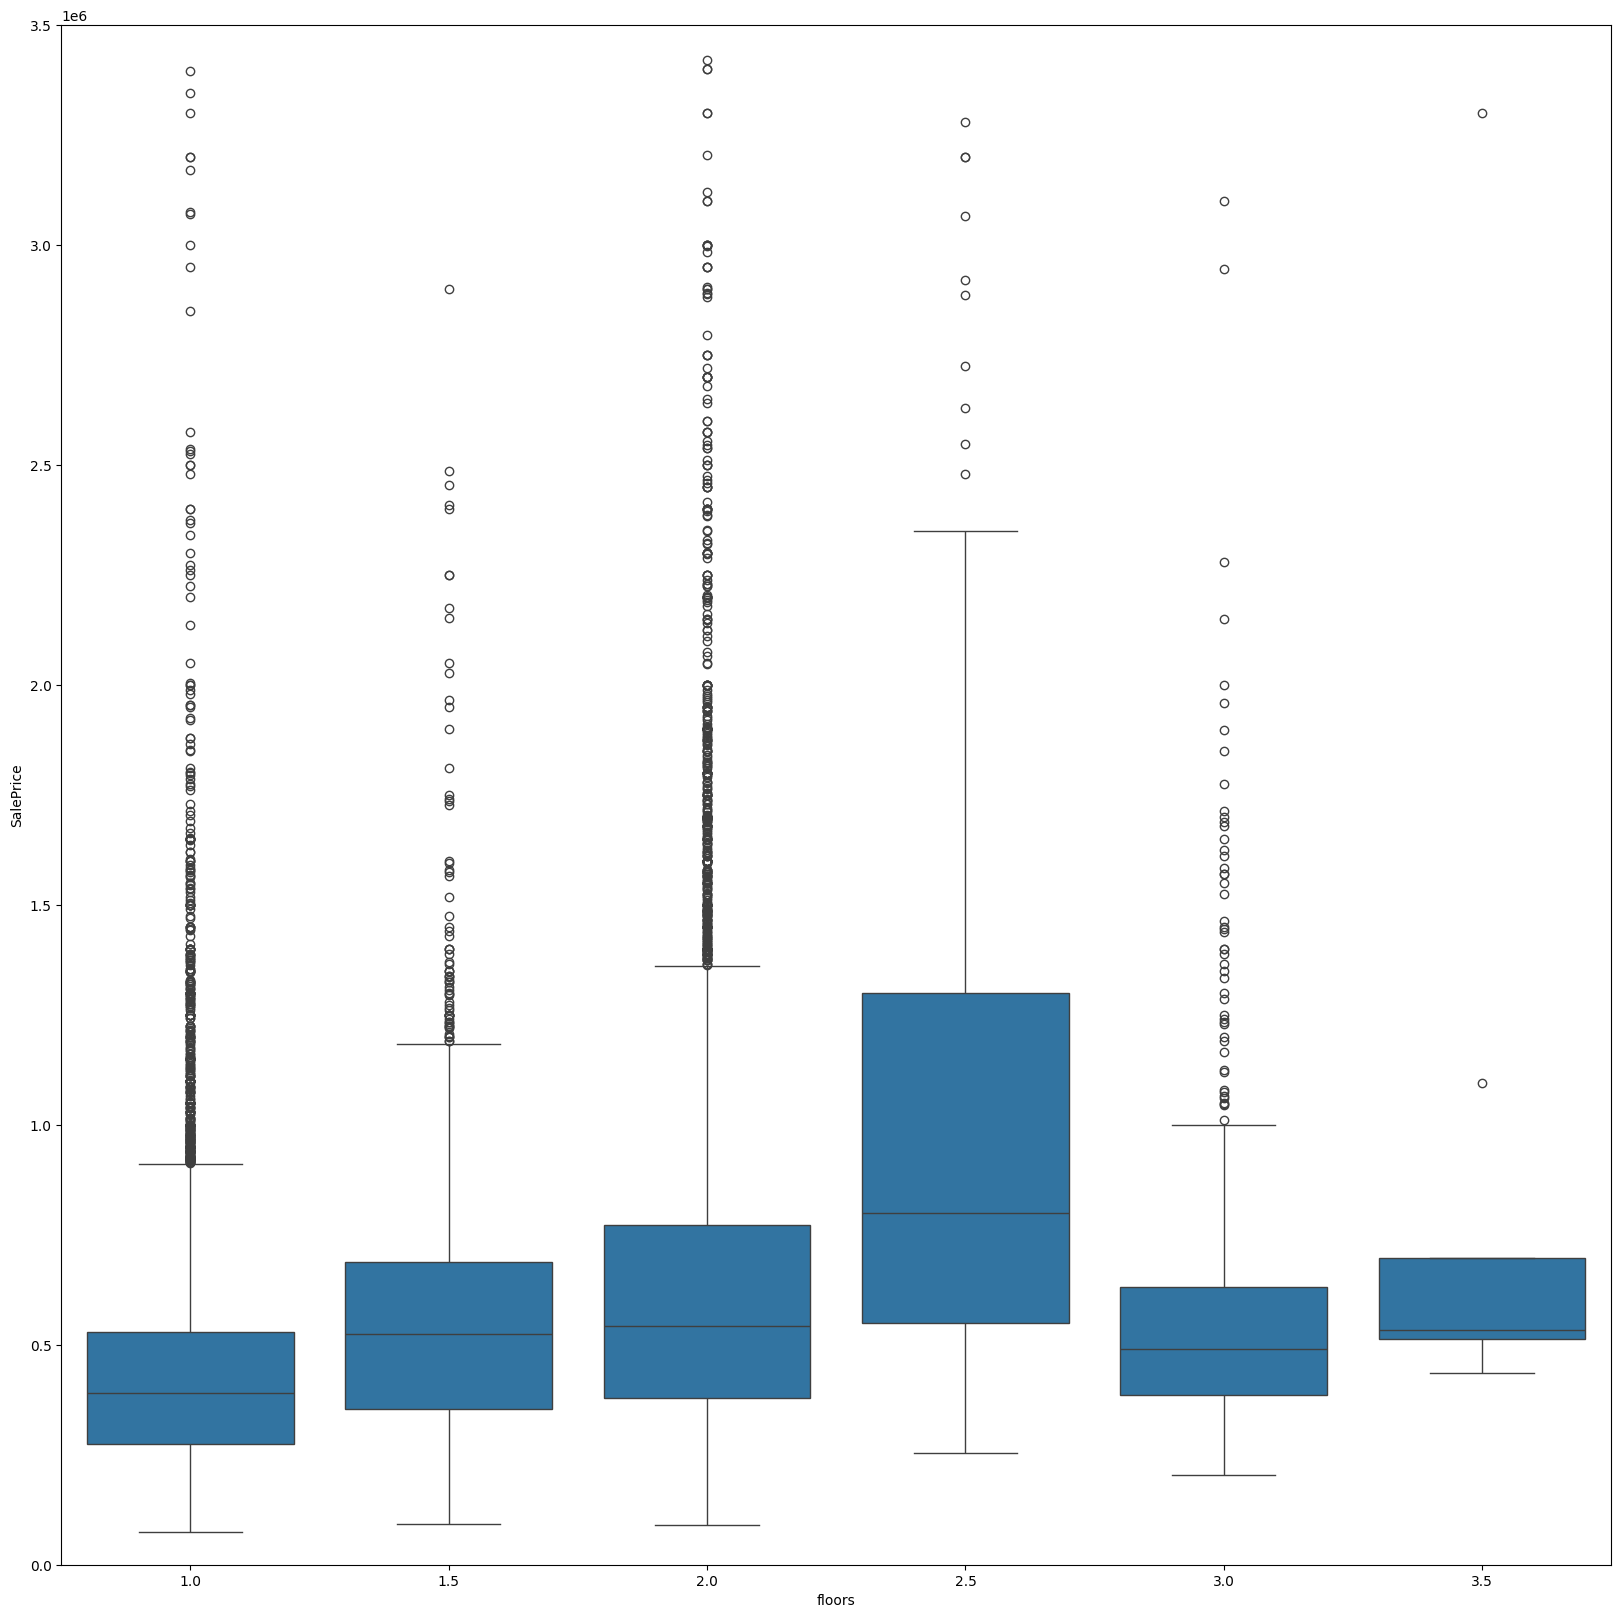

In [16]:
var = 'floors'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 20))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);

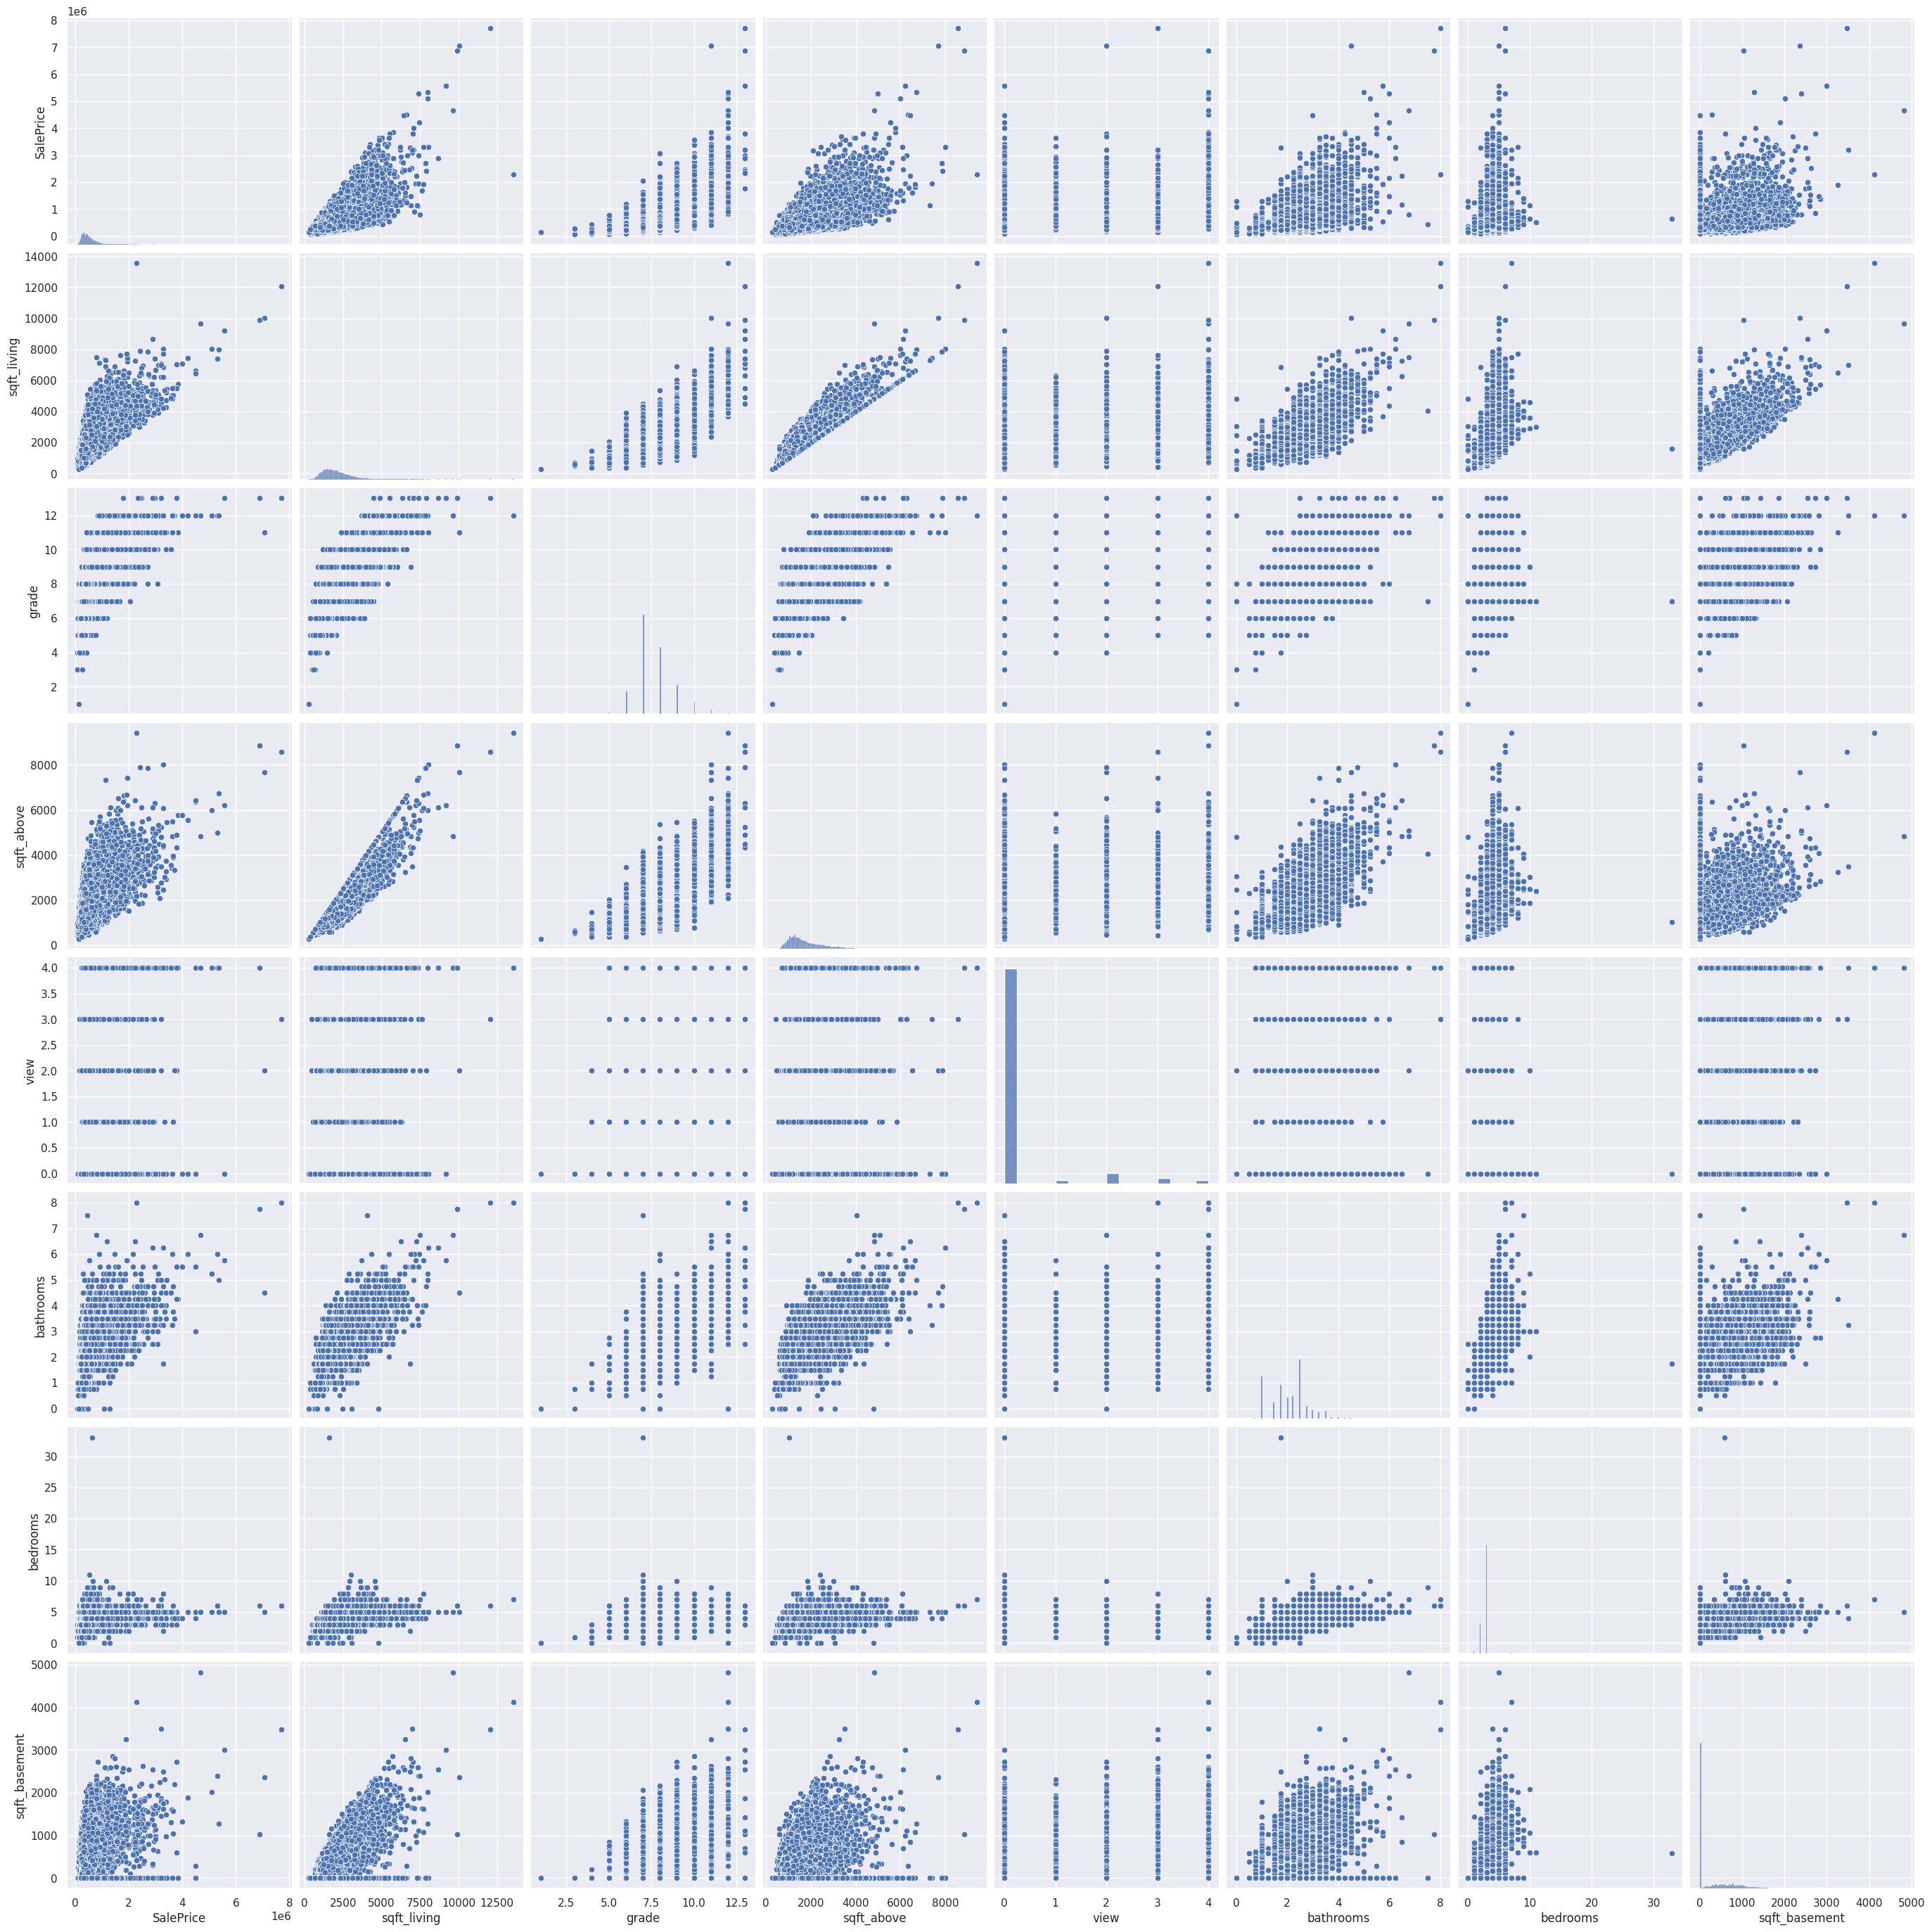

In [17]:
#Pairplots to visualize strong correlation
sns.set()
cols = ['SalePrice', 'sqft_living', 'grade', 'sqft_above', 'view', 'bathrooms','bedrooms','sqft_basement']
sns.pairplot(df_train[cols], height = 3.5)
plt.show();

In [18]:
df_train.dtypes

id                 int64
date              object
SalePrice        float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [19]:
filtered_data = df_train[['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','waterfront','yr_built','lat','bedrooms','long']]

In [20]:
X = filtered_data.values
y = df_train.SalePrice.values

In [21]:
filtered_data.dtypes

sqft_living        int64
grade              int64
sqft_above         int64
sqft_living15      int64
bathrooms        float64
view               int64
sqft_basement      int64
waterfront         int64
yr_built           int64
lat              float64
bedrooms           int64
long             float64
dtype: object

In [22]:
filtered_data.dtypes

sqft_living        int64
grade              int64
sqft_above         int64
sqft_living15      int64
bathrooms        float64
view               int64
sqft_basement      int64
waterfront         int64
yr_built           int64
lat              float64
bedrooms           int64
long             float64
dtype: object

**STEP 5 : SPLITTING DATA INTO TRAINING AND TESTING SET**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)

**STEP 6: APPLYING MACHINE LEARNING MODEL**

# Adaboost Regression

##### The most important parameters are loss, n_estimators and learning_rate.


#####  1. n_estimators - It is the number of models to iteratively train.

#####  2.learning_rate - It is the contribution of each model to the weights and default value for it is 1. There is a trade-off between learning_rate and n_estimators.

##### 3.loss - It is exclusive to AdaBoostRegressor and sets the loss function to use when updating weights. Default value is linear loss function but can be changed to square or exponential.

In [24]:
adaboost=AdaBoostRegressor(n_estimators=50, learning_rate=0.2,loss='exponential').fit(X_train, y_train)
predict = adaboost.predict(X_test)
r2score = r2_score(predict,y_test)

In [25]:
# Calculating R2 Score
r2score

0.4970123525010365

In [26]:
# Calculating Mean Sqaured Error & Root Mean Squared Error
mse = mean_squared_error(y_test, predict)

rmse = math.sqrt(mse)

print(rmse)

205566.68212543108


In [27]:
import datetime, pytz; 
print("Current Time in IST:", datetime.datetime.now(pytz.utc).astimezone(pytz.timezone('Asia/Kolkata')).strftime('%Y-%m-%d %H:%M:%S'))


Current Time in IST: 2025-02-11 20:34:18
